**Steps to preprocess EEG data generally include the following:**<br/>
*1. Importing the raw data*<br/>
*2. Bandpass filter*<br/>
*3. Re-reference data*<br/>
*4. Inspect electrodes and reject noisy channels*<br/>
*5. Epoch the data*<br/>
*6. Inspect and reject noisy epochs*<br/>
*7. Run independent component analysis and reject noisy components*<br/>
*8. Save preprocessed data*<br/>

================================== Importing the required Libraries ===========================

In [21]:
import sys
import numpy as np
from PCA import pca
import pandas as pd
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn import decomposition
from CAR_Filter import car_filter
from scipy.optimize import minimize
from Plot_Features import plot_features
from Channel_Locations import channel_locations

========================================= Functions ==================================

In [19]:
# =============================================== Preparing data =========================================================
def Prepare_data(data, channels=None):  
    # ?------------------------------------------- Check type data -------------------------------------------      
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # !--------------------------------------- Check dimensional data ----------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
    # *--------------------------------------------- Set channels --------------------------------------------
    if channels is not None:
        data.columns=channels 
    else:
        data.columns = np.arange(1,data.shape[1]+1)
         
    return data, data.columns

# ================================================= Plot data ============================================================
def plot_data(data, Fs=None, channels=None, first_point=0, last_point=100, normalize_data='on'):
    # ?--------------------------- Check type, dimensional data & set channels -------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
        
    if 'DataFrame' not in str(type(data)):     
        data = pd.DataFrame(data)
        
    if channels is not None:
        data.columns=channels 
    else:
        data.columns = np.arange(1,data.shape[1]+1)
    # *------------------------------------------ Normalize data ---------------------------------------------
    if normalize_data == 'on':
        data = (data-np.min(data.values, axis=0))/(np.max(data.values, axis=0)-np.min(data.values, axis=0))
    # !-------------------------------------------- Set figure -----------------------------------------------   
    _, axs = plt.subplots(nrows=1,sharey='row', figsize=(7,5))

    data = data.iloc[first_point:last_point,:]
    if Fs is not None and np.array(Fs) > 0:
        time = (np.linspace(start=first_point/Fs, stop=last_point/Fs, num=len(data))).flatten()
        axs.plot(time, data + 1*np.arange(data.shape[1],0,-1))
        axs.set_xlabel('Time (sec)', fontsize=10)
    else:
        axs.plot(data + 1*np.arange(data.shape[1],0,-1))
        axs.set_xlabel('sample', fontsize=10)
    axs.set_ylim([np.min(1*np.arange(data.shape[1],0,-1))+np.min(data.iloc[:,data.shape[1]-1]), np.max(1*np.arange(data.shape[1],0,-1))+np.max(data.iloc[:,0])])
    axs.set_yticks((1*np.arange(data.shape[1],0,-1)))
    axs.set_yticklabels(data.columns)
    axs.tick_params(axis='x', labelsize=8)
    axs.tick_params(axis='y', labelsize=8)
    axs.set_ylabel('Channels', fontsize=10)
    axs.autoscale(enable=None, axis="y", tight=True)
    axs.tick_params(axis='y', color='k', labelcolor='k')

*1. Importing the raw data*

In [4]:
df=pd.read_excel("EEG_Data.xlsx",sheet_name=None)
print(f"List of sheets: {df.keys()}")

List of sheets: dict_keys(['data', 'time', 'channels', 'event', 'urevent', 'Fs'])


In [5]:
data=df['data']
time=df['time']                         # Time (msec)
Fs=df['Fs']                             # Sampling rate (Hz)
channels=df['channels']['labels']       # Name of channel
Th=df['channels']['Th']                 # Theta for plot channels
Rd=df['channels']['Rd']                 # Radius for plot channels

*1.1. Preparing data*

In [6]:
data, channels = Prepare_data(data, channels)

*1.2. Plot data & channel locations*

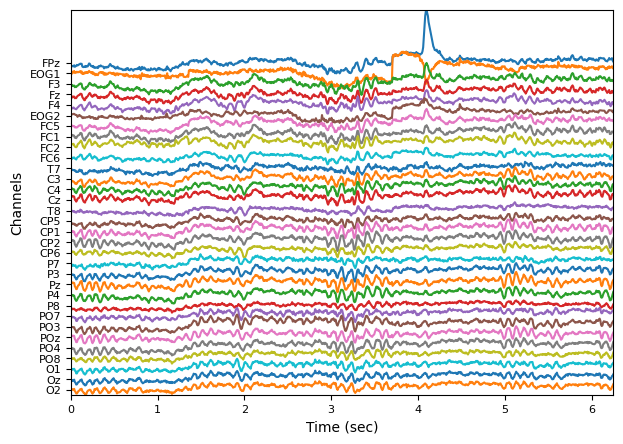

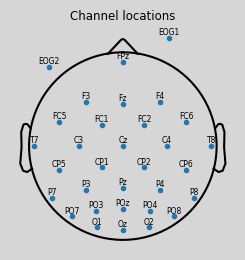

In [7]:
plot_data(data, Fs, channels, first_point=0, last_point=800, normalize_data='off')
channel_locations(Th, Rd, channels)

**Principal Component Analysis (PCA):**<br/>
*Article: Analysis the effect of PCA for feature reduction in non-stationary EEG based motor imagery of BCI system.*<br/>
PCA serves as a valuable tool for extracting meaningful information from the multichannel EEG data by transforming it into a new set of orthogonal variables called principal components (maximize variance). The first principal component explains the most variance, the second explains the second most, and so on.<Br/>
 - **Step 1: Data Centering**<br>Subtract the mean of each feature (column) from the data matrix to center it around the origin. $X_{centered}= X- mean(X)$<br>
 - **Step 2: Compute the Covariance Matrix**<br>Calculate the covariance matrix of the centered data. If X is the centered data matrix with rows as observations and columns as features, the covariance matrix C is given by: $C=X_{centered}X_{centered}^{T}/(n-1)\rightarrow$ Where n is the number of samples.
 - **Step 3: Compute Eigenvectors and Eigenvalues**<br>Calculate the eigenvectors and eigenvalues of the covariance matrix. Eigenvectors represent the directions (principal components) in which the data varies the most, and eigenvalues indicate the amount of variance along each eigenvector. $C*V_{i}=E_{i}*V_{i}\rightarrow$  E: eigenvalue and V: eigenvector.<br/>
 - **Step 4: Select Principal Components**<br/>Sort the eigenvalues in decreasing order. The eigenvectors corresponding to the highest eigenvalues are the principal components that capture the most variance in the data.<br/>
- **Step 5: Project Data onto Principal Components**<br/>Project the centered data onto the selected principal components to obtain the reduced-dimensional representation. If *P* is a matrix of the selected principal components, the transformed data *Y* is given by: $Y=X_{centered}.P$


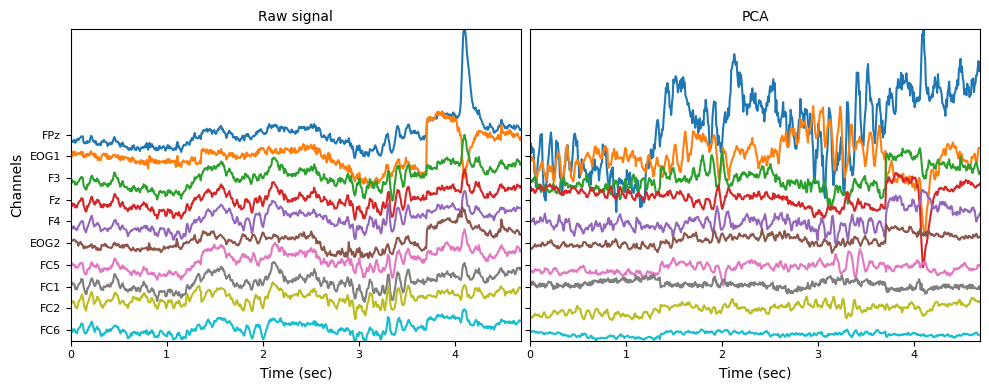

In [8]:
data_features = pca(data, ncomponents=np.min(data.shape))   
plot_features(data, data_features, Fs, channels, first_point=0, last_point=600, num_chan=10, type_feature='PCA')

**Common Average Reference (CAR):**<br/>
*Article: Analysis the effect of PCA for feature reduction in non-stationary EEG based motor imagery of BCI system.*<br/>
CAR improve the quality of EEG data by removing or reducing common sources of noise, such as the placement of electrodes, cable movement, or external electromagnetic interference or muscle activity.$\rightarrow$ *Improving the signal-to-noise ratio of the EEG data.*<br/>

**The Common Average Reference technique involves the following steps:**<br/>
 - *Calculating the Average Signal:* Calculate the average signal across all electrodes at each time point. This average represents the common noise present in the recording.
 - *Subtracting the Average Signal:* Subtract the calculated average signal from the individual electrode signals. This helps remove the common noise component.

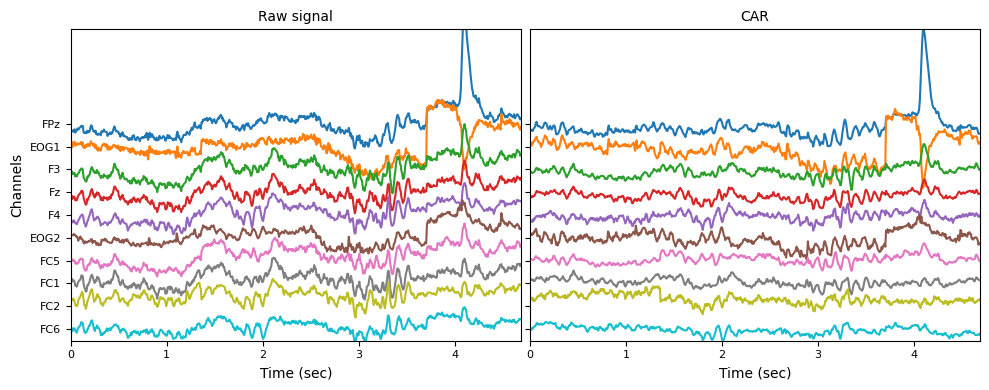

In [9]:
data_features = car_filter(data)   
plot_features(data, data_features, Fs, channels, first_point=0, last_point=600, num_chan=10, type_feature='CAR')

**Small Laplacian Technique:**<br/>
*Article: Analysis the effect of PCA for feature reduction in non-stationary EEG based motor imagery of BCI system.*<br/>
It  is a spatial filtering technique used in EEG signal processing. It aims to enhance spatial resolution by highlighting local changes in EEG signal activity while attenuating more widespread activity.<br/>
Let X be the original EEG signal from electrode i, and $N_{i}$ be the set of neighboring electrodes of electrode i. The Small Laplacian $L_{i}$ for electrode i is calculated as follows:
$L_{i}=X_{i} - {1 \over | N_{i}|}\sum_{j\epsilon N_{i}}{X_{j}}$<br/>
  - *Neighborhood Definition:* Determine the set of neighboring electrodes for each electrode. Typically, a set of adjacent electrodes is chosen.
  - *Calculation:* For each electrode, calculate the Small Laplacian by subtracting the average of neighboring electrodes' signals from the signal of interest.

In [48]:
# ?------------------------------------------- Check type data -------------------------------
if 'Series' not in str(type(Th)):      # Check type Th
    Th = pd.Series(Th)
if 'Series' not in str(type(Rd)):      # Check type Rd
    Rd = pd.Series(Rd)
# *-------------------------------------- Convert degree to radian ---------------------------
if Th.max() > 20:
    Th = (np.pi/180)*Th
elif Rd.max() > 20:
    Rd = (np.pi/180)*Rd
# ----------------------------------------- Euclidean distance -------------------------------
for i in range(data.shape[1]):
    dis = np.zeros(data.shape[1])
    for j in range(data.shape[1]):  
        dis[j] = np.linalg.norm(Th[i] - Rd[j])
    ind = np.argsort(dis)  # Sort distance
    
    if type_filter == 'LL':  # ============= Low Laplacian method ================
        ind = ind[1:9]
    elif type_filter == 'HL':  # ============ High Laplacian method ==============
        ind = ind[9:21]
    dis = dis[ind]
    dis1 = np.zeros(len(ind))
    for n in range(0, len(ind)):  # Euclidean distance for X-axis
            dis1[n] = np.linalg.norm(position_xy[0, channel] - position_xy[0, Ind[n]])
            Ind1 = np.argsort(Dis1)
            Ind1 = Ind1[0:2]
    

In [47]:
ind

array([ 1,  5, 14, 10, 19, 23, 24, 28, 31, 29, 30,  0, 27, 25, 15,  9, 18,
        6, 26,  2, 20,  4, 22, 11, 12,  3, 21, 17, 16,  8,  7, 13],
      dtype=int64)

In [ ]:


            
           
            
            for L in range(0, len(Ind)):  # Euclidean distance for Y-axis
                Dis1[L] = np.linalg.norm(position_xy[1, channel] - position_xy[1, Ind[L]])
            Ind2 = np.argsort(Dis1)
            Ind2 = Ind2[0:2]
            In = np.concatenate((Ind1, Ind2), axis=0)
            D = dis[In]
            In = Ind[In]
            W = (1 / D) / sum(1 / D)
            Dis = np.zeros((np.shape(data_filter)[0], 4))
            for r in range(0, 4):
                Dis[:, r] = data_filter[:, In[r]] * W[r]
            Output_SpatialFilter[:, channel] = data_filter[:, channel] - np.sum(Dis, axis=1)"""

**Independent Component Analysis (ICA)**<br/>https://www.mriquestions.com/uploads/3/4/5/7/34572113/ica_math.pdf<br/>
In EEG signal processing, ICA is applied to disentangle mixed sources, such as muscle activity and eye movements, from the underlying neural signals recorded in EEG data. In fact, ICA decompose these mixed signals into their underlying, statistically independent components, enabling researchers to better understand the distinct sources contributing to the recorded data.<br/>
ICA process involves estimating both the mixing matrix A and the independent source signals S(t) to maximize the statistical independence of the source signals from the observed EEG signals. 
*$x_{j}=a_{j1}s_{1}+a_{j2}s_{2}+...+a_{jn}s_{n} \rightarrow X(t)= As(t)\rightarrow w=A^{-1} \rightarrow s(t)= wx(t)$*. where:<br/>
*X(t): Observed EEG signals matrix with time points as rows and electrode channels as columns.*<br/>
*A: Mixing matrix (mapping from sources to electrodes).*<br/>
*S(t): Matrix of independent source signals.*<br/>
**Process**
1. Center x by subtracting the mean *$\rightarrow x_{c} = x-mean(x)$* & covariance ($x_{c} $) 
2. Compute the eigenvalues and eigenvectors in order to aligning the first principal component with the eigenvector of the highest eigenvalue
2. Whiten x $\rightarrow$ Whitening involves linearly transforming the observation vector such that its components are uncorrelated and have unit variance ($cov(x_{w}x_{w}^{T})=I$)
3. Choose a random initial value for the de-mixing matrix w
4. Calculate the new value for w
5. Normalize w
6. Check whether algorithm has converged and if it hasn’t, return to step 4
7. Take the dot product of w and x to get the independent source signals



Kurtosis is the classical method of measuring NonGaussianity. When data is preprocessed to have unit variance, kurtosis is equal to the fourth moment of the data.

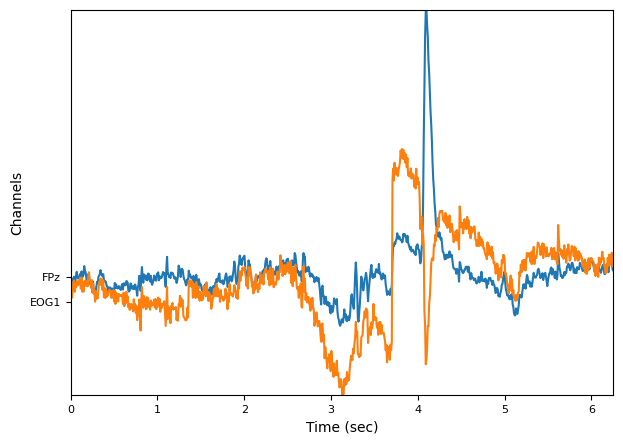

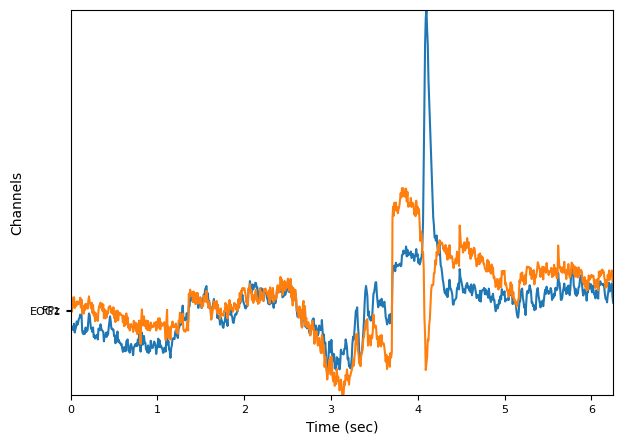

In [20]:
data_centered = data- np.mean(data, axis=0)                          # Center the data (time points x electrode channels)
data_cov = np.cov(data_centered, rowvar=False)                       # Compute the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(data_cov)                  # Compute the eigenvalues and eigenvectors
dig_eigenvalues = np.diag(1.0 / np.sqrt(eigenvalues))                # Calculate the diagonal matrix of eigenvalues raised to the power of -0.5
whitening_matrix = np.dot(np.dot(eigenvectors, dig_eigenvalues), eigenvectors.T)  # Compute the whitening matrix
X_white = np.dot(data_centered, whitening_matrix)                    # Apply the whitening transformation to data_centered
data_features = pd.DataFrame(X_white)
#plot_features(data, data_features, Fs, channels, first_point=0, last_point=600, num_chan=10, type_feature='ICA')
plot_data(data_features.iloc[:,0:2], Fs, channels[0:2], first_point=0, last_point=800, normalize_data='off')
plot_data(data.iloc[:,0:2], Fs, channels[0:2], first_point=0, last_point=800, normalize_data='off')

In [ ]:
def g(data):
    # Define a non-Gaussian function (e.g., cube)
    return data ** 3

def g_prime(data):
    # Derivative of the non-Gaussian function (e.g., 3 * x^2)
    return 3 * data ** 2

def constraint_function(W, constraint_matrix):
    # Compute the constraint violations for each constraint
    constraint_violations = np.dot(constraint_matrix, W)
    return constraint_violations

def constrained_fast_ica(X, n_components, constraint_matrix, max_iterations=1000, tolerance=1e-6):
    n_samples, n_features = X.shape
    W = np.random.rand(n_components, n_features)
    
    for iteration in range(max_iterations):
        prev_W = W.copy()
        
        # Orthogonalize W
        W = W - np.dot(np.dot(W, W.T), W)
        
        for i in range(n_components):
            wx = np.dot(W[i], X.T)
            W[i] = np.mean(g(wx)) - np.mean(g_prime(wx)) * W[i]
            
        # Apply the constraint function
        constraints = {'type': 'ineq', 'fun': constraint_function, 'args': (constraint_matrix,)}
        optimization_result = minimize(objective_function, W.flatten(), constraints=constraints)
        W = optimization_result.x.reshape(n_components, n_features)
        
        # Normalize W
        norms = np.linalg.norm(W, axis=1)
        W /= norms.reshape(-1, 1)
        
        # Check for convergence
        if np.allclose(W, prev_W, atol=tolerance):
            break
    
    S = np.dot(W, X.T)
    return S, W


n_components = 10  # Specify the number of independent components you want to estimate
S_estimated, W_estimated = constrained_fast_ica(data, n_components, constraint_matrix)


In [ ]:
transformer = decomposition.FastICA(n_components=32, whiten='unit-variance', random_state=42)
X_transformed = transformer.fit_transform(data)
X_transformed.shape
plot_data(X_transformed[:,0:3], first_point, last_point,channels=None, Fs=None, normalize_data='on')
plot_data(data.iloc[:,1:3], first_point, last_point,channels=None, Fs=None, normalize_data='on')

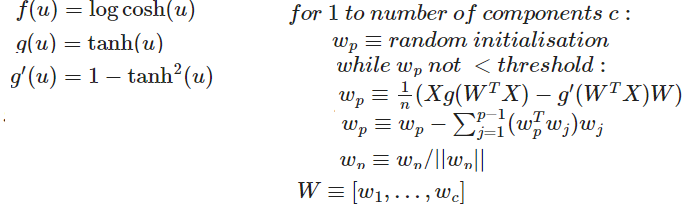

In [24]:
data_centered = data - np.mean(data, axis=0)                   # Center x by subtracting the mean (Remove overall row means of data)
cov_matrix = np.cov(data_centered.T)                           # compute the covariance matrix
U, eigenvalues, eigenvectors = np.linalg.svd(cov_matrix)       # Single value decoposition
diag = np.diag(1.0 / np.sqrt(eigenvalues))                     # Calculate diagonal matrix of eigenvalues
whitening = np.dot(U, np.dot(diag, U.T))                       # Calculate whitening matrix (correlations between the signals are removed and their variances equal unity.)
data_whitening = data_centered.dot(whitening)                  # Project onto whitening matrix
weight = np.random.rand(data.shape[1], data.shape[1])          # Initialize random weights

alpha = 1
threshold=1e-8
epochs=20
for i in range(data_whitening.shape[1]):
    w = weight[i, :].copy().reshape(data_whitening.shape[1], 1)
    w = w / np.sqrt((w ** 2).sum())
    
    j = 0
    lim = 100
    while ((lim > threshold) & (j < epochs)):
        
        ws = np.dot(w.T, data_whitening.T)                         # Dot product of weight and signal
        wg = np.tanh(ws * alpha).T                                 # Pass w*s into contrast function g
        wg_ = (1 - np.square(np.tanh(ws))) * alpha                 # Pass w*s into g prime
        weight_new = (data_whitening * wg).mean(axis=0) - wg_.mean() * w.squeeze() # Update weights
        weight_new = weight_new - np.dot(np.dot(weight_new, weight[:j].T), weight[:j])  # Decorrelate weights 
        weight_new = weight_new / np.sqrt((weight_new ** 2).sum())
        lim = np.abs(np.abs((weight_new * w.flatten()).sum()) - 1)     # Calculate limit condition
        weight[i, :] = weight_new  # Update weights
        j += 1   # Update counter 
    

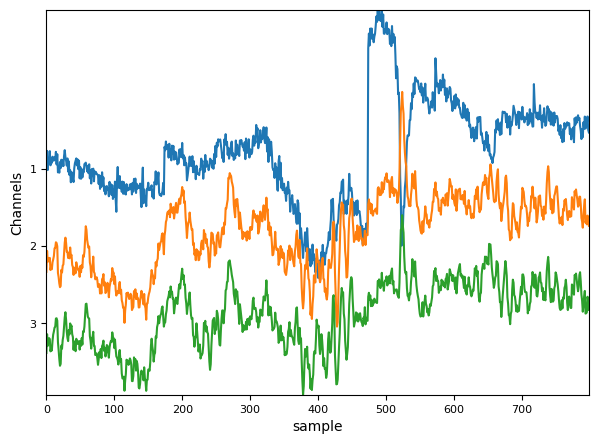

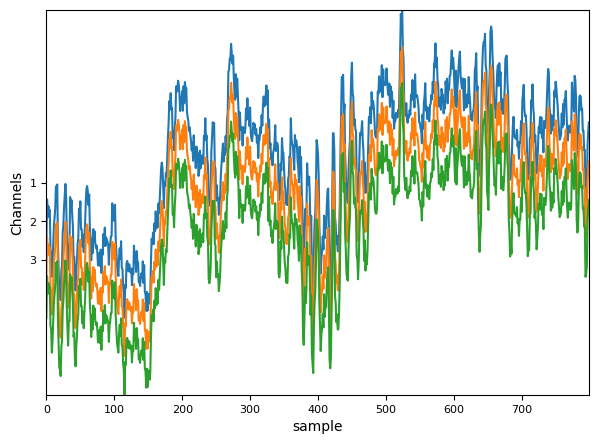

In [46]:
u = data_centered.dot(weight.T)
first_point = 0
last_point = 800
dat =data.iloc[:,1:4]
plot_data(dat, first_point, last_point,channels=None, Fs=None, normalize_data='off')
plot_data(u.iloc[:,1:4], first_point, last_point,channels=None, Fs=None, normalize_data='off')


In [71]:
# Initialize ICA training
DEFAULT_BLOCK = np.ceil(min(5*np.log(30504),0.3*30504)); # heuristic 
block = DEFAULT_BLOCK
lastt=np.fix((30504/block-1)*block+1)
BI=block*np.eye(ncomps,ncomps)
delta=np.zeros((1,chans*ncomps))

changes = []
degconst = 180/np.pi
startweights = weights
prevweights = startweights
oldweights = startweights
prevwtchange = np.zeros((chans,ncomps))
oldwtchange = np.zeros((chans,ncomps))
DEFAULT_MAXSTEPS  = 512;       # top training after this many steps 
maxsteps = DEFAULT_MAXSTEPS
DEFAULT_NSUB   = 1;        # initial default number of assumed sub-Gaussians
lrates = np.zeros((1,maxsteps))
onesrow = np.ones((1,round(block)))
bias = np.zeros((ncomps,1))
signs = np.ones(ncomps)    #  initialize signs to nsub -1, rest +1

"""
signs = np.diag(signs); # make a diagonal matrix
oldsigns = np.zeros(np.size(signs))
signcount = 0;              #counter for same-signs
signcounts = []
urextblocks = 1;   # original value, for resets
old_kk = np.zeros((1,ncomps));  # for kurtosis momemtum"""

'\nsigns = np.diag(signs); # make a diagonal matrix\noldsigns = np.zeros(np.size(signs))\nsigncount = 0;              #counter for same-signs\nsigncounts = []\nurextblocks = 1;   # original value, for resets\nold_kk = np.zeros((1,ncomps));  # for kurtosis momemtum'

*2. Import events and channel locations*

*3. Re-reference and down-sample data*

*4.1. Remove Baseline (Remove mean of each data channel)*<br/>
*4.2. Filter Data*

In [207]:
def center(x):
    mean = np.mean(x, axis=0)
    centered =  x - mean
    return centered, mean
def covariance(x):
    mean = np.mean(x, axis=0)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n
def whiten(x):
    x=x.T
    # Calculate the covariance matrix
    coVarM = covariance(x)
    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)
    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))
    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))
    # Project onto whitening matrix
    Xw = np.dot(whiteM, x)
    return Xw, whiteM
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=20):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T

                # Pass w*s into g prime
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)

                # Update weights
                w = wNew

                # Update counter
                i += 1

            W[c, :] = w.T
    return W

In [ ]:
print(np.round(covariance(Xw)))
W = fastIca(Xw,  alpha=1)
print(W)